# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Описание данных

airports_nearest — расстояние до ближайшего аэропорта в метрах (м)  
balcony — число балконов  
ceiling_height — высота потолков (м)  
cityCenters_nearest — расстояние до центра города (м)  
days_exposition — сколько дней было размещено объявление (от публикации до снятия)  
first_day_exposition — дата публикации  
floor — этаж  
floors_total — всего этажей в доме  
is_apartment — апартаменты (булев тип)  
kitchen_area — площадь кухни в квадратных метрах (м²)  
last_price — цена на момент снятия с публикации  
living_area — жилая площадь в квадратных метрах (м²)  
locality_name — название населённого пункта  
open_plan — свободная планировка (булев тип)  
parks_around3000 — число парков в радиусе 3 км  
parks_nearest — расстояние до ближайшего парка (м)  
ponds_around3000 — число водоёмов в радиусе 3 км  
ponds_nearest — расстояние до ближайшего водоёма (м)  
rooms — число комнат  
studio — квартира-студия (булев тип)  
total_area — площадь квартиры в квадратных метрах (м²)  
total_images — число фотографий квартиры в объявлении  

### Открываем файл с данными и изучите общую информацию. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

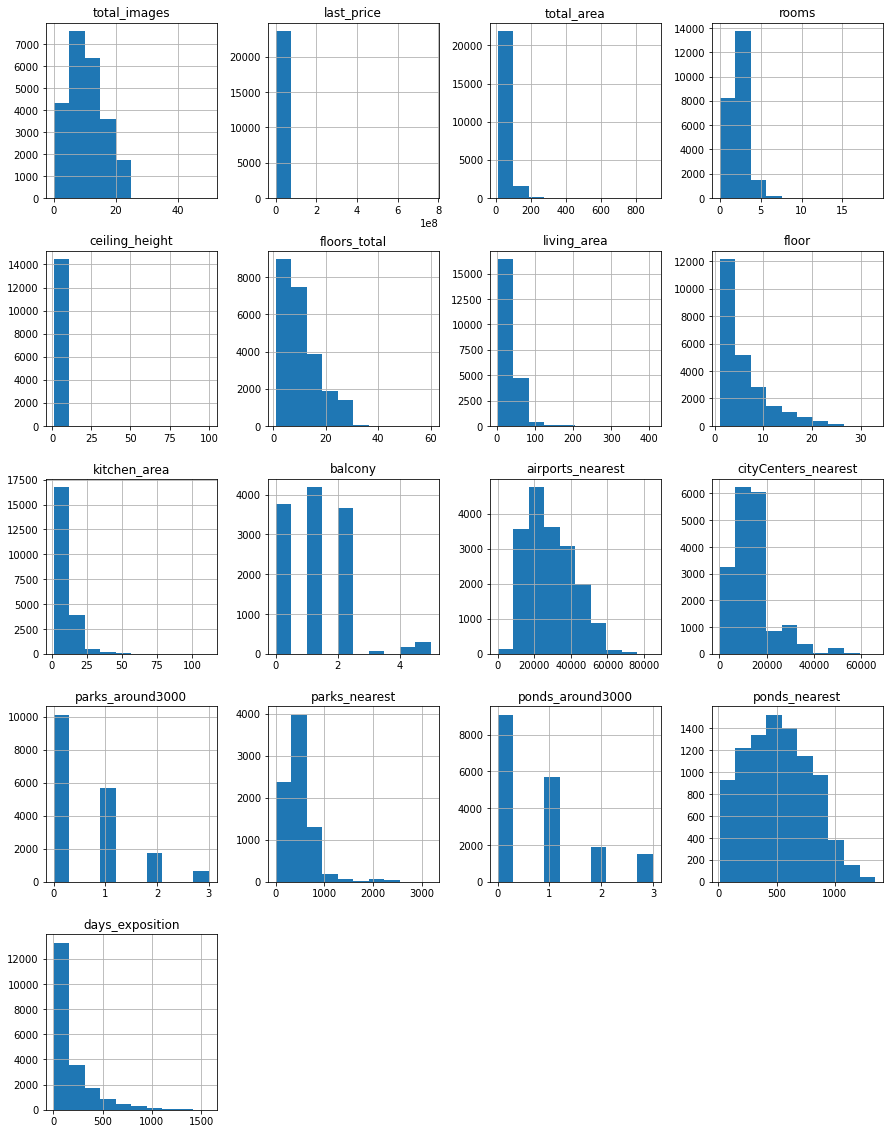

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
data.info()
print(data.head(10))
data.hist(figsize=(15, 20))

### Предобработка данных

In [64]:
# balcony  заполним пустые строки 0. Пропусков много, но впролне вероятно что у этих квартир нет балконов
data['balcony'].fillna(0, inplace=True)
data['balcony'].astype(int)

# не заполенные параметры в 'ceiling_height' заполним медианным значением, так как благодаря типовой советской застройке большинство объектов жилого фонда имееит схожие параметры
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)

# first_day_exposition переведем в формат даты
data["first_day_exposition"] = pd.to_datetime(data["first_day_exposition"],format = '%Y-%m-%dT%H:%M:%S')

#floors_total - пропуско не много, поэтому отбросим заполним средним
data.dropna(subset=["floors_total"],inplace = True,axis = 0 )
# is_appartment заполняем пробелы булевым занчением
data['is_apartment'].fillna(False, inplace=True)

# kitchen_area - не указано в студиях,заменяем пустые строки на 0
data.loc[data["kitchen_area"].isnull(),'studio'] = True
data["kitchen_area"] = data["kitchen_area"].where(~data["kitchen_area"].isnull(),0)

# living_area

data.loc[(data['rooms'] == 0) & (data['studio'] == False), 'rooms'] == 1
living_area_percent = data['living_area'].median() / data['total_area'].median()
data['living_area'].fillna(0, inplace=True)
data['living_area_2'] = data.apply(lambda x:
                                                 x['total_area'] * living_area_percent if x['living_area'] == 0
                                                 else x['living_area'], axis = 1)
data['living_area'] = data['living_area_2']
data.drop(['living_area_2'], axis='columns', inplace=True)

# locality_name - всего 49 пропусков, так как восстановить потерянные данные нельзя удаляем строки
data.dropna(subset=['locality_name'], axis = 0, inplace = True)

# kitchen_area - заполняем схожим принципом
kitchen_area_percent = data['kitchen_area'].median() / data['total_area'].median()
data['kitchen_area_2'] = data.apply(lambda x:
                                                 x['total_area'] * kitchen_area_percent if x['kitchen_area'] == 0
                                                 else x['kitchen_area'], axis = 1)

data['kitchen_area'] = data['kitchen_area_2']
data.drop(['kitchen_area_2'], axis='columns', inplace=True)


#locality_name - отбрасываем незначительные пропуски и переименовываем 
data.dropna(subset=['locality_name'],  inplace=True)
data['locality_name'] = data['locality_name'].str.replace("посёлок", "поселок") 

# parks_around -Заменяем пустые строки на 0
data['parks_around3000'] = data['parks_around3000'].fillna(value=0).astype(int)

# Пponds_around - -Заменяем пустые строки на 0 и приводим к целочисленному занчению
data['ponds_around3000'] = data['ponds_around3000'].fillna(value=0).astype(int)

data['locality_name'] = data['locality_name'].str.lower()
data.duplicated().sum()


0

In [65]:

# days_exposition - исправленный. 
data['days_exposition'].fillna(0, inplace=True)
data['days_exposition'] = data['days_exposition'].astype('int64')
print('Медианное время:', round(data.query('days_exposition != 0')['days_exposition'].median()),'\n')
data['days_exposition'].fillna(95, inplace=True)



Медианное время: 95 



cityCenters_nearest  - отсутствует часть данных, но заполнять медианным или средним значением не имеет смысла, так как это значительно повлияет на стоимость квадратного метра

days_exposition - Если предположить что время размещения не указанно так как объявление еще не снято, но временно заменяем на 0, затем считаем медиану не нулевых результатов(логично что квартира не может продасться за 0 дней) и заменяем значение медианным

living_area - не заполнено в 1903 строках, это около 9% что является достаточно крупным колличеством, поэтому заполняем средним коэффициентом из разницы жилой площади к площади общей. Так как вычеслить объектиную медиану при нулевых значениях не получиться.

### Проведим исследовательский анализ данных

In [66]:
# стоимость квадратного метра
def metr_price (row):
    return row['last_price']/row['total_area']
data['metr_price'] = data.apply(metr_price,axis = 1)

# добавляем столбцы дня недели, месяца и года
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

# сортируем квартиры по этажам
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_type, axis=1)

# Добавляем столбец с расстоянием до центра в км, округляем до целого
data['center_distance'] = data['cityCenters_nearest'] / 1000
data['center_distance'] = data['center_distance'].fillna(value=0).astype(int)

#удаляем выбросы
data.info()
def quartile_range(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    dfq = df.loc[(df[column] < q3 + 1.5*iqr) & (df[column] > q1 - 1.5*iqr), column]
    return dfq
list_features = ['last_price', 'total_area', 'kitchen_area', 'living_area', 'days_exposition', 'ceiling_height', 'rooms']
for col in list_features:
    data[col] = quartile_range(data, col)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

50.0
54.319703932634596


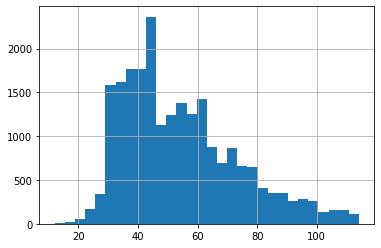

In [67]:
# изучим общую площадь
data['total_area'].hist(bins =30)
print(data['total_area'].median())
print(data['total_area'].mean())

медианое значение:50 среднее значение:54 исходя из графика наиболее распостраненная площадь квартир: 30- 50 метров

30.0
31.544201648008574


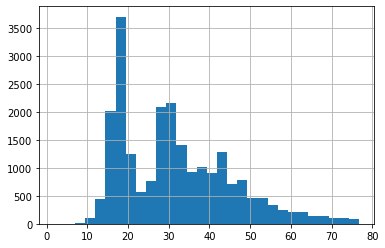

In [68]:
# изучим жилую площадь
data['living_area'].hist(bins =30)
print(data['living_area'].median())
print(data['living_area'].mean())

медианое значение:30 среднее значение:31,5 исходя из графика наиболее распостраненная объемы жилой площади это 15-20 кв.м и 25-30 кв.м. что в соответствуем минимальным стандартам для 1 и 2 комнатных квартир

9.0
9.410773585883897


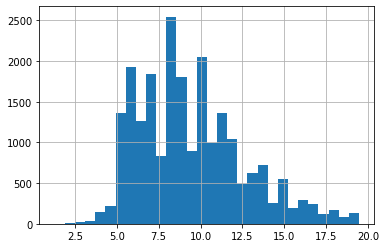

In [69]:
# изучим площадь кухни
data['kitchen_area'].hist(bins =30)
print(data['kitchen_area'].median())
print(data['kitchen_area'].mean())

медианое значение:9 среднее значение:9,5 исходя из графика наиболее распостраненная площадь кухонь от 5 до 12 метров

4400000.0
4837114.547516149


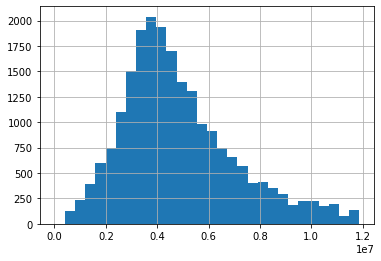

In [70]:
# изучим цены
data['last_price'].hist(bins =30)
print(data['last_price'].median())
print(data['last_price'].mean())

медианое значение:4,4 млн среднее значение:4,8 млн исходя из графика наиболее В основном стоимость квартир - порядка 3,5-4,5 миллионов

2.0
2.0302083779042404


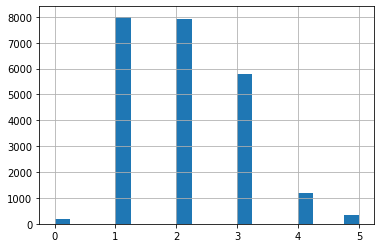

In [71]:
# изучим количество комнат
data['rooms'].hist(bins =20)
print(data['rooms'].median())
print(data['rooms'].mean())

медианое значение:2 среднее значение:2 исходя из графика наиболее наиболее распостраненны двухкомнатные квартиры, хотя кроичество трехкомнатных уступает не значительно

2.65
2.631088782097956


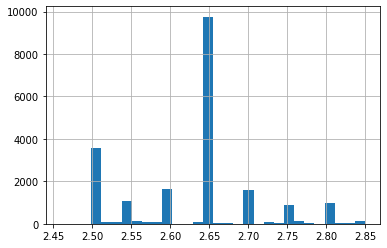

In [72]:
# изучим высотц потолков
data['ceiling_height'].hist(bins =30)
print(data['ceiling_height'].median())
print(data['ceiling_height'].mean())

медианое значение:2,65 среднее значение:2,63 исходя из графика наиболее 2,65 м самая популярная высота потолков

4.0
5.8781243369403775


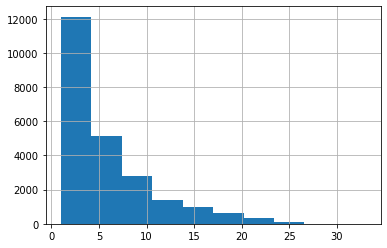

In [73]:
# изучим этажи
data['floor'].hist(bins =10)
print(data['floor'].median())
print(data['floor'].mean())

медианое значение:4 среднее значение:5.8 исходя из графика наиболее как будет видно в следующей диаграмме объявления о продаже квартир на 1 этаже не так велики,исходя из этого большинство квартир продяются на этажах с 2 по 6

<AxesSubplot:>

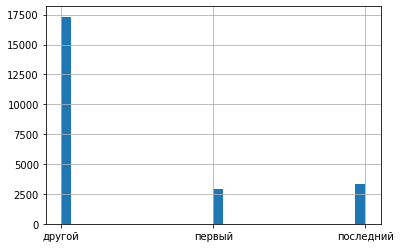

In [74]:
# тип этажа
data['floor_type'].hist(bins =30)

наибольшинство объявление о продаже квартир не на крайних этажах

9.0
10.675875238701463


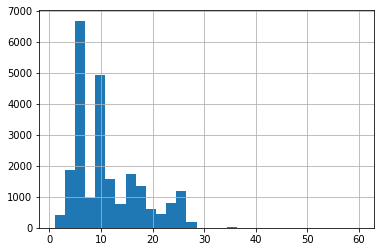

In [75]:
# изучим кэтажность зданий
data['floors_total'].hist(bins =30)
print(data['floors_total'].median())
print(data['floors_total'].mean())

медианое значение:9 среднее значение: с округлением 11 исходя из графика наиболее наиболее распостраненны 5 и 9 этажные дома

13096.5
14192.656056244465


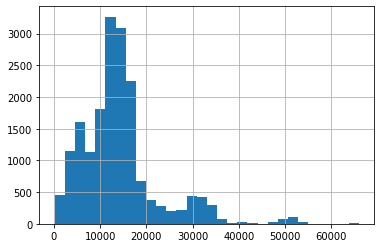

In [76]:
# изучим расстояние до центра
data['cityCenters_nearest'].hist(bins =30)
print(data['cityCenters_nearest'].median())
print(data['cityCenters_nearest'].mean())

медианое значение:13км среднее значение:14км исходя из графика наиболее наиболее распостраненное расстояние до центра 13-15 км

455.0
490.5804483188045


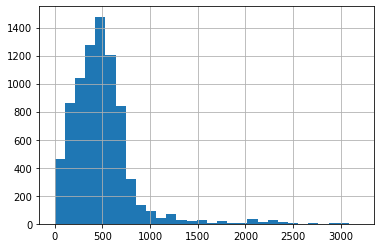

In [77]:
# изучим расстояние до ближайшего парка
data['parks_nearest'].hist(bins =30)
print(data['parks_nearest'].median())
print(data['parks_nearest'].mean())

медианое значение:455м среднее значение:490 м исходя из графика наиболее чаще всего расскотяние составляет около 450-500 метров

26757.0
28797.082700515493


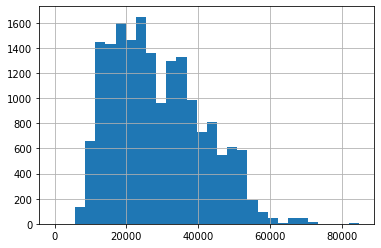

In [78]:
# изучим расстояние до ближайшего аэропорта
data['airports_nearest'].hist(bins =30)
print(data['airports_nearest'].median())
print(data['airports_nearest'].mean())

медианое значение:26,7км среднее значение:28,8 км исходя из графика наиболее  наиболе выделяться расстояния в 25-29 км

6.0
6.401570125185657


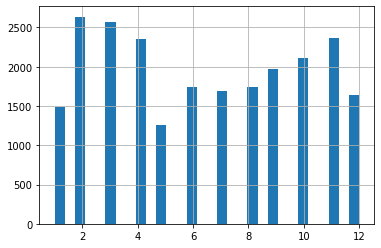

In [79]:
# изучим месяц публикации объявления
data['month'].hist(bins =30)
print(data['month'].median())
print(data['month'].mean())

медианое значение:июль среднее значение:июль исходя из графика наиболее наиболее активные месяца для размещения объявлений это  февраль, март и апрель и ноябрь. По видимому продавцы начинают продажи в началое календарного года или хотят успеть совершить продаж до его завершения, возможно это связанно с налоговыми периодами.

3.0
2.567366857627838


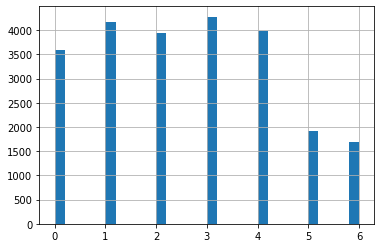

In [80]:
# изучим месяц публикации объявления
data['weekday'].hist(bins =30)
print(data['weekday'].median())
print(data['weekday'].mean())

медианое значение:четверг среднее значение:среда  по графику можно заметить наиболее высокую активность со вторника по пятницу и значительную просадку по выходным, можно предположить что многие объявления публикуются агенствами и риэлторами, которые делают объявления в течении рабочей недели

60.0


count    21539.000000
mean       103.573889
std        111.664697
min          0.000000
25%         18.000000
50%         60.000000
75%        153.000000
max        461.000000
Name: days_exposition, dtype: float64

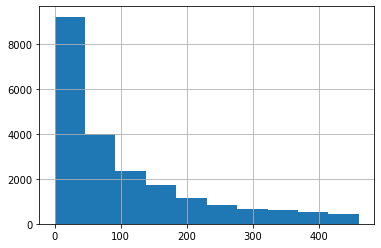

In [81]:
# изучим время продажи
data['days_exposition'].hist(bins =10)
print(data['days_exposition'].median())
data['days_exposition'].describe()

медианное всемя продажи составляет 60 дней, среднее около 104. Некоторые объекты могут продаваться по году и болееЮ но скорее всего это связано с особенностями объекта недвижимости(премиум статусом, эксклюзивностью постройки или расположения и т.п.) Исходя из полуенных данным быстрой продажей можно считать продажу за срок до 18 дней, а медленной более 153 дней.

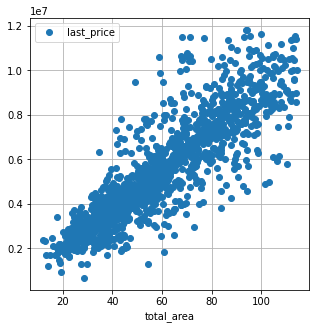

Корреляция цены и площади: 

            last_price  total_area
last_price    1.000000    0.905372
total_area    0.905372    1.000000 



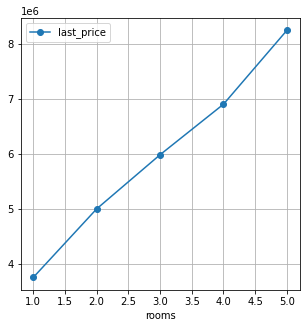

Корреляция цены и числа комнат: 

            last_price     rooms
last_price    1.000000  0.537551
rooms         0.537551  1.000000 



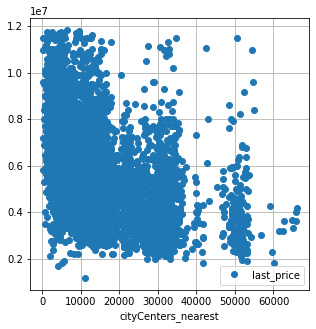

Корреляция цены и удалённости от центра: 

                     cityCenters_nearest  last_price
cityCenters_nearest             1.000000    0.712077
last_price                      0.712077    1.000000 



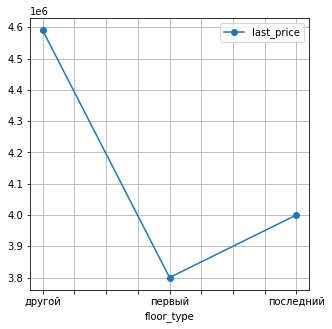

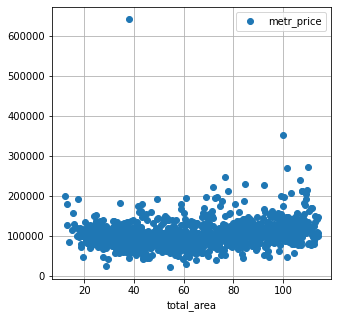

Корреляция цены за квадрат и площади: 

            metr_price  total_area
metr_price    1.000000    0.047408
total_area    0.047408    1.000000 



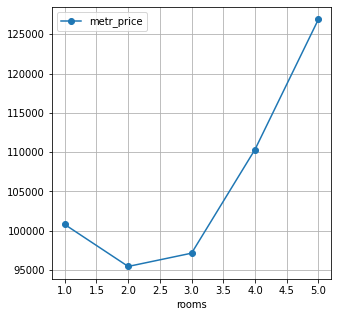

Корреляция цены за квадрат и числа комнат: 

            metr_price     rooms
metr_price    1.000000 -0.263153
rooms        -0.263153  1.000000 



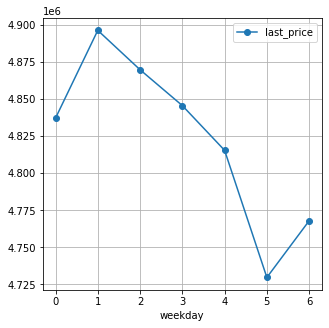

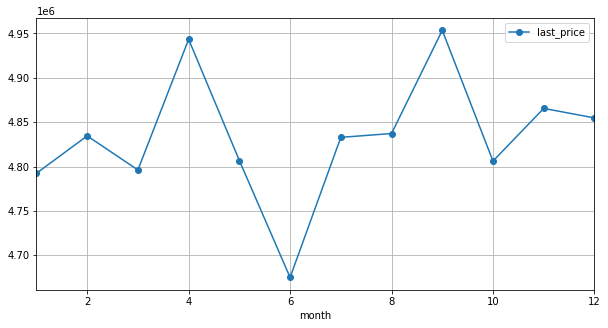

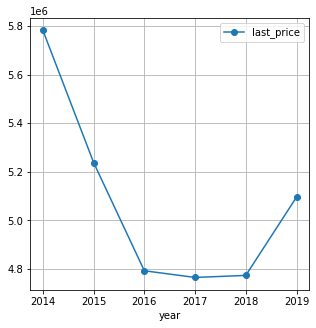

In [82]:
#коредяция цены
# Зависимость цены от площади
(
    data.pivot_table(index='total_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()
print('Корреляция цены и площади:','\n')
print(data.pivot_table(index='floor', values=['total_area', 'last_price']).corr(),'\n')

# Зависимость цены от числа комнат
(
    data.query('rooms > 0').pivot_table(index='rooms', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()
print('Корреляция цены и числа комнат:','\n')
print(data.query('rooms > 0').pivot_table(index='floor', values=['rooms', 'last_price']).corr(),'\n')

# Зависимость цены от удалённости от центра
(
    data.pivot_table(index='cityCenters_nearest', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()
print('Корреляция цены и удалённости от центра:','\n')
print(data.pivot_table(index='floor', values=['cityCenters_nearest', 'last_price']).corr(),'\n')

# Зависимость цены от этажа
(
    data.pivot_table(index='floor_type', values='last_price', aggfunc='median')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()

# Зависимость цены за квадрат от площади
(
    data.pivot_table(index='total_area', values='metr_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()
print('Корреляция цены за квадрат и площади:','\n')
print(data.pivot_table(index='floor', values=['total_area', 'metr_price']).corr(),'\n')


# Зависимость цены за квадрат от числа комнат
(
    data.query('rooms > 0').pivot_table(index='rooms', values='metr_price')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()
print('Корреляция цены за квадрат и числа комнат:','\n')
print(data.query('rooms > 0').pivot_table(index='floor', values=['rooms', 'metr_price']).corr(),'\n')

# Зависимость от дня размещения
(
    data.pivot_table(index='weekday', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()
# Зависимость от месяца размещения
(
    data.pivot_table(index='month', values='last_price')
    .plot(grid=True, style='o-', xlim=(1,12), figsize=(10, 5))
)
plt.show()
# Зависимость от года размещения
(
    data.pivot_table(index='year', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()

Зависимость цены и площади крайне велика(0.91), при увеличении площали растет и цена. При этом число комнат влияет на стоимость, но в значительно меньшей степени(0,54). Зависимость цены от удаленности от центра сказывается значительно сильнее(0,71). Можно сделать вывод что квартиры в центре стоят дороже, при этом их площадь (и/или количество комнат) могут быть меньше чем на окраинах.

Распложение на последнем и особенно на первом этаже снижают стоимость квартиры

Стоимость квадрата обратно пропорциональна числу комнат, наибольшая стоимость у однакомнатных квартир

Зависимость времени размещения
День недели: дороже всего квартиры, опубликованные в среду, дешевле всего - в субботу.
Месяц: дороже всего квартиры, продающиеся с апреля, дешевле всего - с июня, скорее всего это связанно с сезонными отпусками.
Годовая зависимость: в 2014-2015 годах квартиры реско подешевели, скорее всего это связано с началом санкции и уходом части банков выдававших ипотеки. С 2018-2019 года начался постепенный рост цен, скорее всего на него повлияло восстановление экономики и реализация программ государственной поддержки.

In [83]:
# сравнение цен в 10 населённых пунктах с наибольшим числом объявлений.
top_ten_city = data['locality_name'].value_counts().head(10)
top_metr_price = data.query('locality_name in (@top_ten_city.index)').pivot_table(values='metr_price', index='locality_name')
top_metr_price = top_metr_price.astype(int)
top_metr_price.sort_values('metr_price', ascending=False)

,metr_price
locality_name,
санкт-петербург,114868
пушкин,103125
деревня кудрово,92473
поселок парголово,90175
поселок мурино,85629
поселок шушары,78551
колпино,75424
гатчина,68746
всеволожск,68654


Петербург логично самый дорогой город. Далее идут города не сильно удаленные от северной столицы, имеющие парки и прочие привлекальные элементы инфроструктуры.

923974


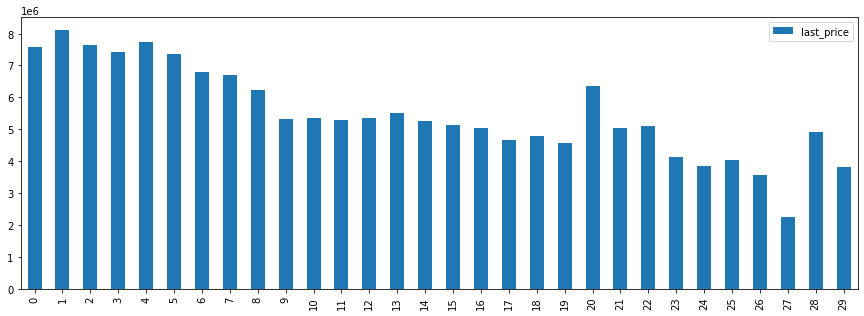

In [84]:
# добавим столбец отражающий расстояние в км заместо м
data['cityCenters_km'] = data['cityCenters_nearest'] / 1000
data['cityCenters_km'] = data['cityCenters_km'].fillna(value=0).astype(int)

# стороим график средней стоимости для каждого км Петербурга

St_Petersburg = data.query('locality_name	== "санкт-петербург"')
cityCenters_km_pivot_table = St_Petersburg.pivot_table(index ='cityCenters_km',
                                                        values = 'last_price',aggfunc = 'mean')
cityCenters_km_pivot_table = cityCenters_km_pivot_table.astype('int')
cityCenters_km_pivot_table['km'] = cityCenters_km_pivot_table.index
cityCenters_km_pivot_table.reset_index(drop = True,inplace = True)
cityCenters_km_pivot_table.plot(y = "last_price",style = 'o',kind = 'bar',figsize = (15,5))
cityCenters_km_pivot_table['km_price'] = cityCenters_km_pivot_table['last_price'][1:] / cityCenters_km_pivot_table['km'][1:]
print(cityCenters_km_pivot_table['km_price'].mean().astype(int))

После 6 км начинается спад, это можно считать приемлемой границей. На расстоянии 20,28 км цена резко повышается повидимо там начинается расположение элитных загородным поселков. В среднем на километр цена снижается на 895039

### Общий вывод

Среднее время продажи 104 дня, наибольшее количтво объялений это квартиры 2 и 3 комнатные в  9 этажных домах.
На стоимость квартир оказывают большое влияние площадь, этажность (первый и последний этажи заметно снижают стоимость) и расстояние до центра
Так же на стоимость оказывает общаяя экономическая ситауция приседшая в 2014-2015 годах к значительному снижению стоимости
